# Image Classification

Creating a Convolutional Neural Network by the combination of Features Network and Classification Network.

## Imports

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import imageio
import cv2
import os
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch as tr
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim

np.random.seed(0)

## Data Preparation and Processing

### Understanding Data

Classes of the Dataset

In [2]:
Classes = os.listdir("Dataset/train")
Num_Classes = len(Classes)
Index2Classes = dict(zip(np.arange(Num_Classes), Classes))
Classes2Index = dict(zip(Classes, np.arange(Num_Classes)))

Paths of the Dataset

In [3]:
TrainImagesPath = "Dataset/train"
ValidImagesPath = "Dataset/val"

Visualizing Images

Church


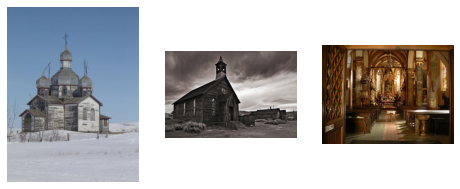

Golf-Ball


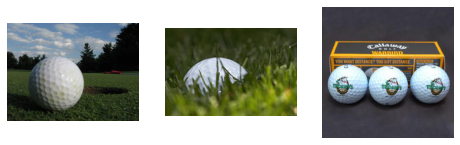

French-Horn


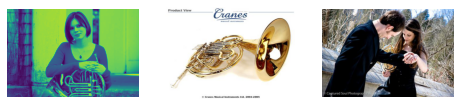

Tench


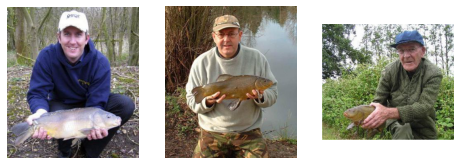

Parachute


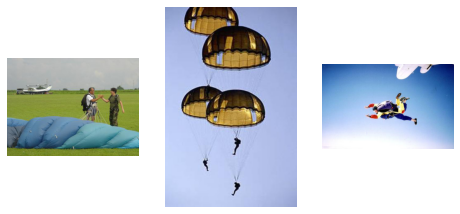

Gas-Pump


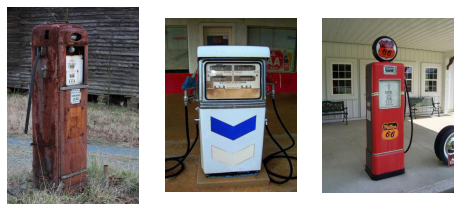

Garbage-Truck


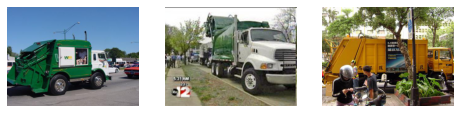

Chain-Saw


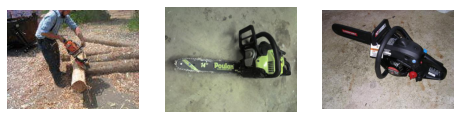

Cassette-Player


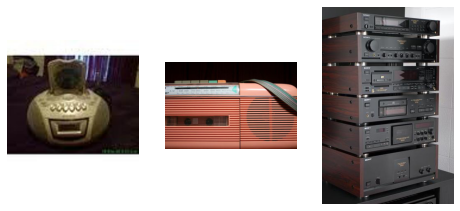

English-Springer


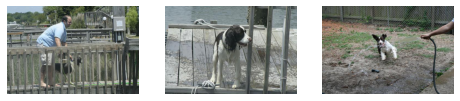

In [4]:
Samples_per_Class = 3
for c in Classes:
	imgpath = os.listdir(TrainImagesPath + "/" + c)
	idxs = np.array(imgpath)[np.random.choice(len(imgpath), Samples_per_Class, replace=False)]
	print (c)

	plt.figure(figsize=(8,6))
	for i, idx in enumerate(idxs):
		img = pimg.imread(TrainImagesPath + "/" + c + "/" + idx)
		plt.subplot(1, Samples_per_Class, i+1)
		plt.axis('off')
		plt.imshow(img.astype('uint8'))
	plt.show()
	

### Dataset and DataLoaders

Creating torch dataset when image of each class are present in their corresponding folders but are seperated by **train** and **valid** folders.

In [5]:
class ImagenetteDataset(Dataset):
	def __init__(self, Images_Directory, Classes, Classes2Index):
		self.Images_Directory = Images_Directory
		self.num_classes = len(Classes)

		# Array for One-Hot Encoding
		OHE = np.eye(self.num_classes)

		# Images and Classes
		self.Images_Path = []
		self.Targets = []
		for c in Classes:
			imgpath = self.Images_Directory + "/" + c
			for filename in os.listdir(imgpath):
				self.Images_Path.append(imgpath + "/" + filename)
				self.Targets.append([Classes2Index[c]])
			
		
	def __getitem__(self, i):
		image = pimg.imread(self.Images_Path[i])
		target = self.Targets[i]

		# Resizing
		image = cv2.resize(image,(224,224))
		image = image/255.0
		try:
			image = image.transpose(2, 0, 1).astype('float32')
		except:
			image = np.array([image, image, image]).astype('float32')
		
		# Converting them to tensors
		image = tr.Tensor(image)
		target = tr.LongTensor(target)
		
		# As it is for an Auto-Encoder
		return image, target
		

	def __len__(self):
		return len(self.Images_Path)

Train and Validation Datasets

In [6]:
Train_Dataset = ImagenetteDataset(TrainImagesPath, Classes, Classes2Index)
Valid_Dataset = ImagenetteDataset(ValidImagesPath, Classes, Classes2Index)

## Features Network

Extracting features from an image.

Source: 
- https://blog.paperspace.com/vgg-from-scratch-pytorch/
- https://debuggercafe.com/implementing-vgg11-from-scratch-using-pytorch/

In [7]:
class Features_Network(nn.Module):
    def __init__(self, latent_dims):
        super(Features_Network, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())          
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.fc = nn.Sequential(
            nn.Linear(7*7*512, latent_dims),
            nn.ReLU())

    def forward(self, inp):
        x = self.layer1(inp)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = x.reshape(x.size(0), -1)
        out = self.fc(x)
        return out

## Classification Network

Creating Classification Network to classify features to their targets.

In [8]:
class Classification_Network(nn.Module):
	def __init__(self, latent_dims, num_classes):
		super(Classification_Network, self).__init__()
		self.fc1 = nn.Sequential(
			nn.Linear(latent_dims, 1024),
			nn.ReLU())
		self.fc2 = nn.Sequential(
			nn.Linear(1024, 1024),
			nn.ReLU())
		self.fc3 = nn.Sequential(
			nn.Linear(1024, num_classes))
			

	def forward(self, inp):
		x = self.fc1(inp)
		x = self.fc2(x)
		out = self.fc3(x)
		return out

## Convolutional Neural Network

Combining both feature extraction and classification models to form a complete convolutional neural network.

In [9]:
class Classifier(nn.Module):
	def __init__(self, latent_dims, Num_Classes):
		super(Classifier, self).__init__()
		self.Features = Features_Network(latent_dims)
		self.Classification = Classification_Network(latent_dims, Num_Classes)  
			
	def forward(self, inp):
		x = self.Features(inp)
		out = self.Classification(x)
		return out

In [10]:
Model = Classifier(2048, Num_Classes)
summary(Model, (3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Features_Network: 1-1                  [-1, 2048]                --
|    └─Sequential: 2-1                   [-1, 64, 112, 112]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 112, 112]        1,792
|    |    └─BatchNorm2d: 3-2             [-1, 64, 112, 112]        128
|    |    └─ReLU: 3-3                    [-1, 64, 112, 112]        --
|    └─Sequential: 2-2                   [-1, 128, 56, 56]         --
|    |    └─Conv2d: 3-4                  [-1, 128, 56, 56]         73,856
|    |    └─BatchNorm2d: 3-5             [-1, 128, 56, 56]         256
|    |    └─ReLU: 3-6                    [-1, 128, 56, 56]         --
|    └─Sequential: 2-3                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         295,168
|    |    └─BatchNorm2d: 3-8             [-1, 256, 56, 56]         512
|    |    └─ReLU: 3-9                    [-1, 256, 56, 56]         --


Layer (type:depth-idx)                   Output Shape              Param #
├─Features_Network: 1-1                  [-1, 2048]                --
|    └─Sequential: 2-1                   [-1, 64, 112, 112]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 112, 112]        1,792
|    |    └─BatchNorm2d: 3-2             [-1, 64, 112, 112]        128
|    |    └─ReLU: 3-3                    [-1, 64, 112, 112]        --
|    └─Sequential: 2-2                   [-1, 128, 56, 56]         --
|    |    └─Conv2d: 3-4                  [-1, 128, 56, 56]         73,856
|    |    └─BatchNorm2d: 3-5             [-1, 128, 56, 56]         256
|    |    └─ReLU: 3-6                    [-1, 128, 56, 56]         --
|    └─Sequential: 2-3                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         295,168
|    |    └─BatchNorm2d: 3-8             [-1, 256, 56, 56]         512
|    |    └─ReLU: 3-9                    [-1, 256, 56, 56]         --


## Training Auto-Encoder

Training Parameters

In [11]:
Batch_Size = 32
Epochs = 50

DataLoaders

In [12]:
Train_DataLoader = DataLoader(Train_Dataset, batch_size=Batch_Size, shuffle=True)
Valid_DataLoader = DataLoader(Valid_Dataset, batch_size=Batch_Size, shuffle=True)

Training Settings

In [13]:
# Initialize Optimizer
Optimizer = optim.Adam(Model.parameters(), lr=0.001)

# Loss Function
LossFunction = nn.CrossEntropyLoss()

# Device
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")

Train-Step and Validation-Step

In [14]:
def TrainStep(model, X, y, lossfunction, optimizer, device, calculate_accuracy=True):
	if calculate_accuracy:
		y = y.flatten()
	
	optimizer.zero_grad()
	y_pred = model(X.to(device))
	loss = lossfunction(y_pred, y.to(device))
	loss.backward()
	optimizer.step()

	if calculate_accuracy:
		preds = tr.argmax(y_pred, dim=1).cpu().numpy()
		num_correct_predictions = accuracy_score(y.numpy(), preds, normalize=False)
		num_predictions = y.shape[0]
		return loss.item(), num_correct_predictions, num_predictions
	else:
		num_predictions = y.shape[0]
		return loss.item(), num_predictions

def ValidStep(model, X, y, lossfunction, device, calculate_accuracy=True):
	if calculate_accuracy:
		y = y.flatten()
	
	y_pred = model(X.to(device))
	loss = lossfunction(y_pred, y.to(device))

	if calculate_accuracy:
		preds = tr.argmax(y_pred, dim=1).cpu().numpy()
		num_correct_predictions = accuracy_score(y.numpy(), preds, normalize=False)
		num_predictions = y.shape[0]
		return loss.item(), num_correct_predictions, num_predictions
	else:
		num_predictions = y.shape[0]
		return loss.item(), num_predictions

Training the Model

In [15]:
Training_Loss = []
Training_Accuracy = []
Validation_Loss = []
Validation_Accuracy = []

for epoch in range(1, Epochs+1):
	print ("Epoch-{}:".format(epoch), end="")

	# Training
	train_loss = 0
	num_correct = 0
	num_samples = 0
	with tqdm(Train_DataLoader, unit=" batches") as tepoch:
		for batch_input, batch_target in tepoch:
			tepoch.set_description("Train")

			loss,correct,samples = TrainStep(Model,batch_input,batch_target,LossFunction,Optimizer,device)
			train_loss += (loss*samples)
			num_correct += correct
			num_samples += samples

			tepoch.set_postfix(loss = np.round(train_loss/num_samples, decimals=3), acc = np.round(num_correct/num_samples, decimals=3))

	Training_Loss.append(np.round(train_loss/num_samples, decimals=3))
	Training_Accuracy.append(np.round(num_correct/num_samples, decimals=3))

	# Validation
	val_loss = 0
	num_correct = 0
	num_samples = 0
	with tqdm(Valid_DataLoader, unit=" batches") as tepoch:
		for batch_input, batch_target in tepoch:
			tepoch.set_description("Valid")

			loss,correct,samples = ValidStep(Model,batch_input,batch_target,LossFunction,device)
			val_loss += (loss*samples)
			num_correct += correct
			num_samples += samples

			tepoch.set_postfix(val_loss = np.round(val_loss/num_samples, decimals=3), val_acc = np.round(num_correct/num_samples, decimals=3))
		
	Validation_Loss.append(np.round(val_loss/num_samples, decimals=3))
	Validation_Accuracy.append(np.round(num_correct/num_samples, decimals=3))

	print ("Training-Loss = {}, Training-Accuracy = {}, Validation-Loss = {}, Validation-Accuracy = {}".format(Training_Loss[-1], Training_Accuracy[-1], Validation_Loss[-1], Validation_Accuracy[-1]))
	print ("-"*100)
	print ()

Epoch-1:

Valid: 100%|██████████| 123/123 [00:11<00:00, 10.64 batches/s, val_acc=0.282, val_loss=1.96]


Training-Loss = 2.143, Training-Accuracy = 0.228, Validation-Loss = 1.959, Validation-Accuracy = 0.282
----------------------------------------------------------------------------------------------------

Epoch-2:

Valid: 100%|██████████| 123/123 [00:11<00:00, 10.56 batches/s, val_acc=0.398, val_loss=1.73]


Training-Loss = 1.834, Training-Accuracy = 0.35, Validation-Loss = 1.728, Validation-Accuracy = 0.398
----------------------------------------------------------------------------------------------------

Epoch-3:

Valid: 100%|██████████| 123/123 [00:11<00:00, 10.50 batches/s, val_acc=0.449, val_loss=1.61]


Training-Loss = 1.654, Training-Accuracy = 0.431, Validation-Loss = 1.612, Validation-Accuracy = 0.449
----------------------------------------------------------------------------------------------------

Epoch-4:

Valid: 100%|██████████| 123/123 [00:11<00:00, 10.69 batches/s, val_acc=0.491, val_loss=1.5] 


Training-Loss = 1.504, Training-Accuracy = 0.488, Validation-Loss = 1.495, Validation-Accuracy = 0.491
----------------------------------------------------------------------------------------------------

Epoch-5:

Valid: 100%|██████████| 123/123 [00:11<00:00, 10.69 batches/s, val_acc=0.534, val_loss=1.36]


Training-Loss = 1.369, Training-Accuracy = 0.536, Validation-Loss = 1.365, Validation-Accuracy = 0.534
----------------------------------------------------------------------------------------------------

Epoch-6:

Valid: 100%|██████████| 123/123 [00:11<00:00, 10.55 batches/s, val_acc=0.589, val_loss=1.28]


Training-Loss = 1.221, Training-Accuracy = 0.597, Validation-Loss = 1.278, Validation-Accuracy = 0.589
----------------------------------------------------------------------------------------------------

Epoch-7:

Valid: 100%|██████████| 123/123 [00:11<00:00, 10.59 batches/s, val_acc=0.628, val_loss=1.16]


Training-Loss = 1.084, Training-Accuracy = 0.644, Validation-Loss = 1.163, Validation-Accuracy = 0.628
----------------------------------------------------------------------------------------------------

Epoch-8:

Valid: 100%|██████████| 123/123 [00:11<00:00, 10.56 batches/s, val_acc=0.637, val_loss=1.18]


Training-Loss = 0.964, Training-Accuracy = 0.684, Validation-Loss = 1.178, Validation-Accuracy = 0.637
----------------------------------------------------------------------------------------------------

Epoch-9:

Valid: 100%|██████████| 123/123 [00:11<00:00, 10.60 batches/s, val_acc=0.646, val_loss=1.18]


Training-Loss = 0.876, Training-Accuracy = 0.713, Validation-Loss = 1.176, Validation-Accuracy = 0.646
----------------------------------------------------------------------------------------------------

Epoch-10:

Valid: 100%|██████████| 123/123 [00:11<00:00, 10.68 batches/s, val_acc=0.675, val_loss=1.04]

Training-Loss = 0.773, Training-Accuracy = 0.745, Validation-Loss = 1.045, Validation-Accuracy = 0.675
----------------------------------------------------------------------------------------------------



Plotting Loss and Accuracy

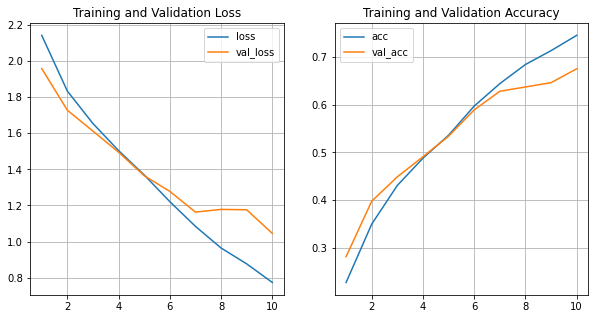

In [16]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(np.arange(1,Epochs+1), Training_Loss, label="loss")
plt.plot(np.arange(1,Epochs+1), Validation_Loss, label="val_loss")
plt.grid()
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(1,Epochs+1), Training_Accuracy, label="acc")
plt.plot(np.arange(1,Epochs+1), Validation_Accuracy, label="val_acc")
plt.grid()
plt.title("Training and Validation Accuracy")
plt.legend()

plt.show()

Saving Model

In [17]:
tr.save(Model.Features.state_dict(), "Weights/Features_Network")
tr.save(Model.Classification.state_dict(), "Weights/Classification_Network")